# Mount Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Menghitung Jumlah Dataset

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import cv2
import glob
import numpy as np # linear algebra
import pandas as pd

In [ ]:
train_image_names = glob.glob('/content/drive/MyDrive/dataset_new/train/*/*')
test_image = glob.glob('/content/drive/MyDrive/dataset_new/test/*/*')
print('total seluruh gambar training:', len(train_image_names))
print('total seluruh gambar training:', len(test_image))
train_image_names = pd.Series(train_image_names)
test_images = pd.Series(test_image)

total seluruh gambar training: 380
total seluruh gambar training: 50


In [ ]:
train_df = pd.DataFrame()

# generate Filename field
train_df['Filename'] = train_image_names.map(lambda img_name: img_name.split("/")[-1])

# generate Label field
train_df['ClassName'] = train_image_names.map(lambda img_name: img_name.split("/")[-2])

train_df.head()

,Filename,ClassName
0,herpes-zoster-85.jpg,herpes
1,herpes-zoster-139.jpg,herpes
2,herpes-zoster-133.jpg,herpes
3,herpes-zoster-90.jpg,herpes
4,herpes-zoster-82.jpg,herpes


In [ ]:
class_id_distribution = train_df['ClassName'].value_counts()
class_id_distribution.head(10)

herpes        76
tahi lalat    76
jerawat       76
kutil         76
flek hitam    76
Name: ClassName, dtype: int64

<BarContainer object of 5 artists>

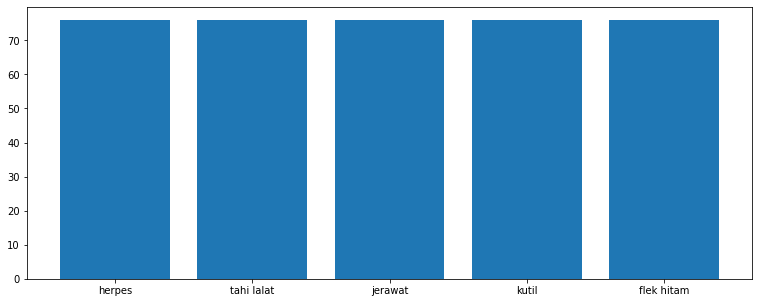

In [ ]:
plt.figure(figsize=(13,5))
plt.xticks(np.arange(43))
plt.bar(class_id_distribution.index, class_id_distribution.values)

# Image Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
import numpy as np

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
        rescale=1./255,
        # rotation_range=40,
        # zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2
        )

test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 120 using train_datagen generator
train_dataset = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/dataset_new/train/',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 200x200
        # color_mode='grayscale',
        batch_size=32,
        class_mode='categorical',
        subset='training')
test_dataset = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/dataset_new/test/',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 200x200
        # color_mode='grayscale',
        batch_size=32,
        class_mode='categorical')
validation_dataset = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/dataset_new/train/',  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 200x200
        # color_mode='grayscale',
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 305 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 75 images belonging to 5 classes.


# Menampilkan Label

In [ ]:
print(train_dataset.class_indices)

{'flek hitam': 0, 'herpes': 1, 'jerawat': 2, 'kutil': 3, 'tahi lalat': 4}


# Membuat Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Activation, Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [ ]:
# Arsitektur CNN dengan 2 Convolution Layers
model = tf.keras.Sequential()

# Convolution layer pertama
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', 
                                 activation='relu', input_shape=(224,224,3))) 
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Convolution layer kedua
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', 
                                 activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Flattern 
model.add(tf.keras.layers.Flatten())
# Fully connected layer
# model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
# model.add(tf.keras.layers.Dense(64, activation='relu'))
# model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

# Take a look at the model summary
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 224, 224, 64)      832       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 112, 112, 32)      8224      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 56, 56, 32)       0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 100352)            0         
                                                                 
 dense_20 (Dense)            (None, 256)             

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

# Training 

In [ ]:
history = model.fit(train_dataset, 
      epochs=10,
      validation_data=validation_dataset)

Epoch 1/10
10/10 [==============================] - 11s 1s/step - loss: 5.1523 - accuracy: 0.2131 - val_loss: 1.5222 - val_accuracy: 0.3867
Epoch 2/10
10/10 [==============================] - 9s 916ms/step - loss: 1.4153 - accuracy: 0.4164 - val_loss: 1.0272 - val_accuracy: 0.6533
Epoch 3/10
10/10 [==============================] - 9s 942ms/step - loss: 1.1584 - accuracy: 0.5246 - val_loss: 0.8231 - val_accuracy: 0.6800
Epoch 4/10
10/10 [==============================] - 9s 951ms/step - loss: 0.9629 - accuracy: 0.6656 - val_loss: 0.8545 - val_accuracy: 0.5600
Epoch 5/10
10/10 [==============================] - 9s 951ms/step - loss: 0.9021 - accuracy: 0.6426 - val_loss: 0.6982 - val_accuracy: 0.6933
Epoch 6/10
10/10 [==============================] - 9s 987ms/step - loss: 0.7692 - accuracy: 0.7148 - val_loss: 0.5626 - val_accuracy: 0.8000
Epoch 7/10
10/10 [==============================] - 9s 918ms/step - loss: 0.6131 - accuracy: 0.7836 - val_loss: 0.5060 - val_accuracy: 0.8133
Epoch 8/

# Evaluasi Model

In [ ]:
model.evaluate(test_dataset)

2/2 [==============================] - 1s 537ms/step - loss: 0.9920 - accuracy: 0.7400


[0.9919545650482178, 0.7400000095367432]

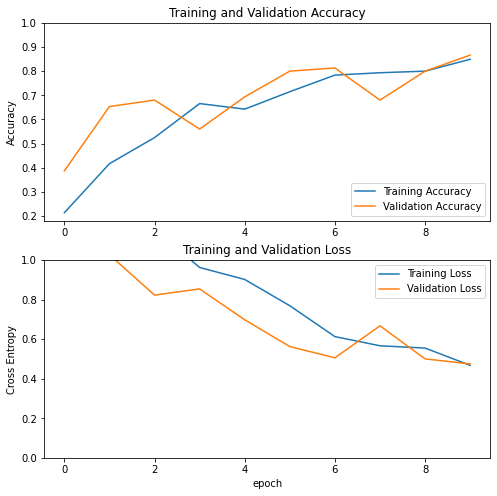

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Menyimpan Model

In [ ]:
model.save("model_2.h5")

# Prediksi Gambar Dengan Model

In [ ]:
class_dict = {0:'flek hitam',
              1:'herpes',
              2:'jerawat',
              3:'kutil',
              4:'tahi lalat'}

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.utils import load_img, img_to_array 
from tensorflow.keras.activations import softmax

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = tf.keras.utils.load_img(path, target_size=(224, 224))
  img = tf.keras.utils.img_to_array(img)
  # plt.imshow(img/255.)
  img = np.expand_dims(img, axis=0)
  # images = np.vstack([img])
  
  classes = model.predict(img)
  # print(classes)
  confidence = round(100 * (np.max(classes[0])), 2)
  classes = np.argmax(classes, axis=1)
  prediksi = np.argmax(img, axis=1)
  print(classes)
  # print(prediksi)
  # classes = class_dict[classes]
  # print(classes)
  print(confidence)

Saving herpes-simplex-31.jpg to herpes-simplex-31.jpg
1/1 [==============================] - 0s 15ms/step
[1]
100.0
